# Running image segmentation on the CIL project
## Link
https://www.kaggle.com/c/cil-road-segmentation-2020/data

## Initialization

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import pathlib

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Network parameters
NETWORK_WIDTH = 400
NETWORK_HEIGHT = 400
TESTDATA_WIDTH = 608
TESTDATA_HEIGHT = 608
OUTPUT_CHANNELS = 2

## Dataset load and prepare

In [3]:
#Not to run everytime
#Zip neeeds to be in the jupyter folder
!rm -rf data
!mkdir data
!unzip -q cil-road-segmentation-2020.zip -d data

### Import data in TF format

In [4]:
data_dir = pathlib.Path('.', 'data', 'training', 'training').resolve()
list_ds = tf.data.Dataset.list_files(str(data_dir/'images/*'))

In [5]:
def read_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (NETWORK_WIDTH, NETWORK_HEIGHT))
    img = tf.image.convert_image_dtype(img, tf.float32) # Cast and normalize the image to [0,1]
    img = tf.image.per_image_standardization(img)
    return img

def read_mask(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (NETWORK_WIDTH, NETWORK_HEIGHT))
    img = tf.round(tf.cast(img, tf.float32) / 255.0)
    return img

def process_path(file_path):
    img = read_image(file_path)
    maskPath = tf.strings.regex_replace(file_path, 'images', 'groundtruth')
    mask = read_mask(maskPath)
    #tf.print(file_path)
    #tf.print(maskPath)
    return img, mask

In [6]:
def leftright(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask
def rot90(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask
def rot180(img, mask):
    img = tf.image.rot90(img, k=2)
    mask = tf.image.rot90(mask, k=2)
    return img, mask
def rot270(img, mask):
    img = tf.image.rot90(img, k=3)
    mask = tf.image.rot90(mask, k=3)
    return img, mask
def random_characteristics(img, mask):
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_contrast(img, 0.8, 1.3)
    img = tf.image.random_saturation(img, 0.8, 1.3)
    return img, mask

def extendDataSet(dataset):
    outset = dataset.map(leftright)
    outset = outset.concatenate(dataset.map(rot90))
    outset = outset.concatenate(dataset.map(rot90).map(leftright))
    outset = outset.concatenate(dataset.map(rot180))
    outset = outset.concatenate(dataset.map(rot180).map(leftright))
    outset = outset.concatenate(dataset.map(rot270))
    outset = outset.concatenate(dataset.map(rot270).map(leftright))
    
    outset = outset.map(random_characteristics)
    return outset

In [7]:
whole_ds = list_ds.map(process_path)

ds_size = len(list(whole_ds))
valid_count = int(ds_size*0.2)
valid_ds = whole_ds.take(valid_count)
train_ds = whole_ds.skip(valid_count)
train_ds = train_ds.concatenate(extendDataSet(train_ds))

TRAIN_LENGTH = len(list(train_ds))
BATCH_SIZE = 20
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE // 4

#The datasets to train the model with. Copied from the example. Doesn't work without these operations
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_ds.batch(BATCH_SIZE)

### Have a look at an example datapoint

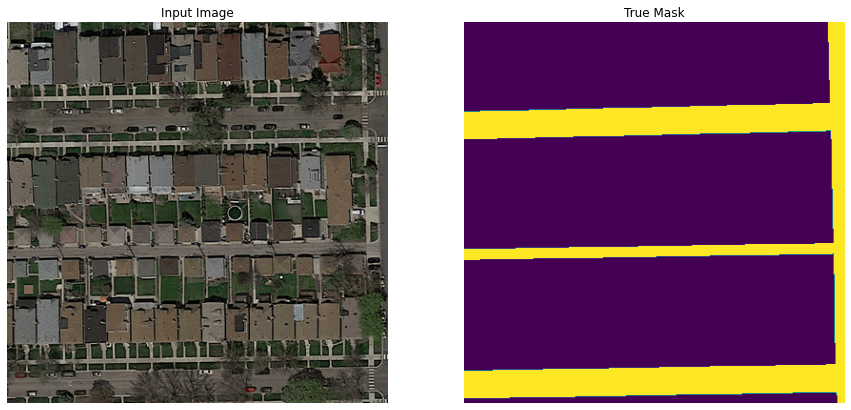

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#Change take parameter to display a different datapoint
for image, mask in whole_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model

To accommodate for the training data picture size of 400x400 I modified the network from the example.
Instead of 5 reductions, only 4 are used, because the last reduction would reduce the dimensions from 25x25 to 13x13 which cannot be upsampled afterwards. I wonder if that's the right solution, given that the test dataset then has a picture size of 400x400

### Downsampling

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[NETWORK_WIDTH, NETWORK_HEIGHT, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

### Upsampling

In [10]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

### Assemble the model

In [11]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[NETWORK_WIDTH, NETWORK_HEIGHT, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-2]
  skips = reversed(skips[:-2])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Have a look at it

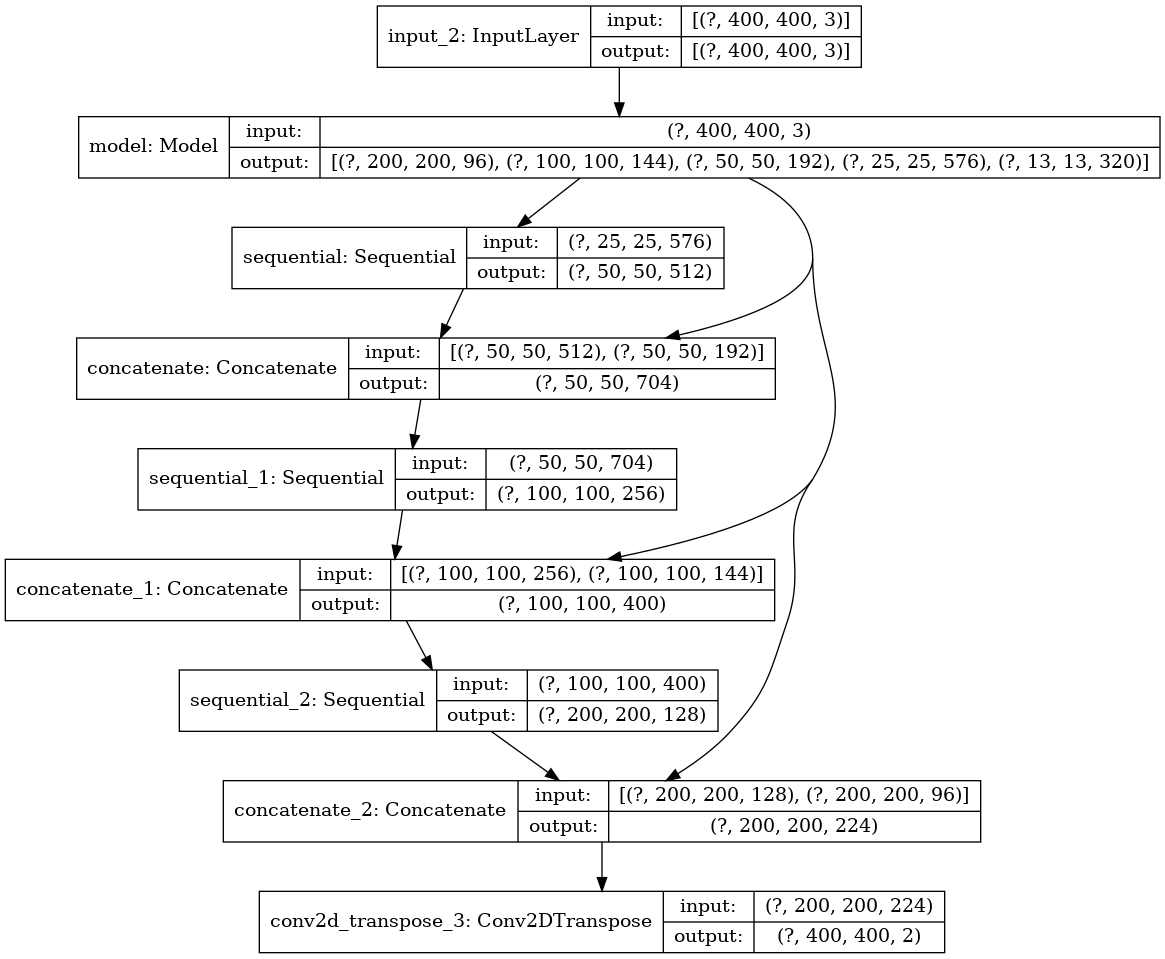

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

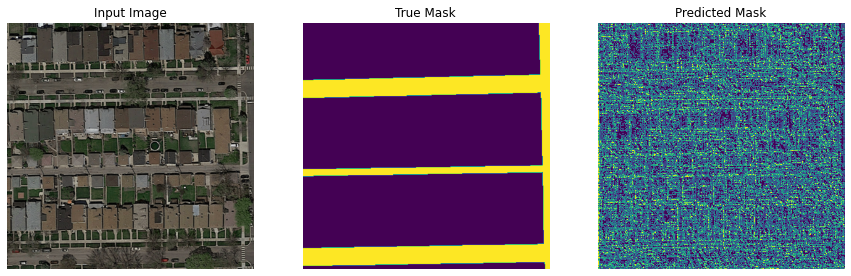

In [13]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
#Displays the predicted mask for the sample_image taken above, with random network parameters
show_predictions()

### Train the model

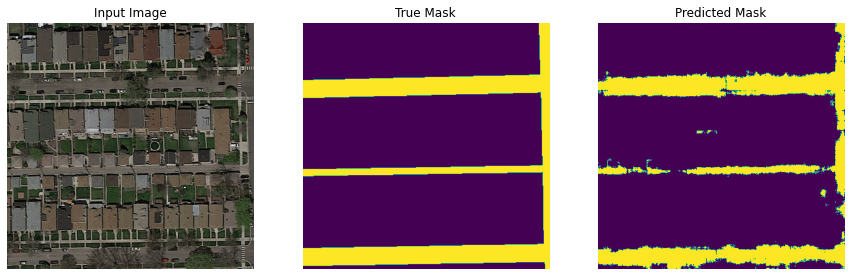


Sample Prediction after epoch 30

8/8 [==============================] - 3s 331ms/step - loss: 0.1799 - accuracy: 0.9239 - val_loss: 0.1914 - val_accuracy: 0.9195


In [14]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
EPOCHS = 30

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

### Have a look at the losses

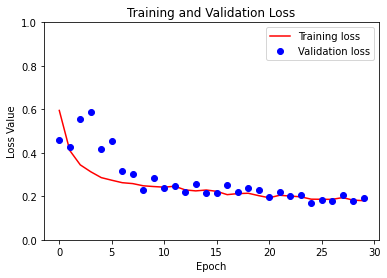

In [15]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Look at a prediction for the validation dataset

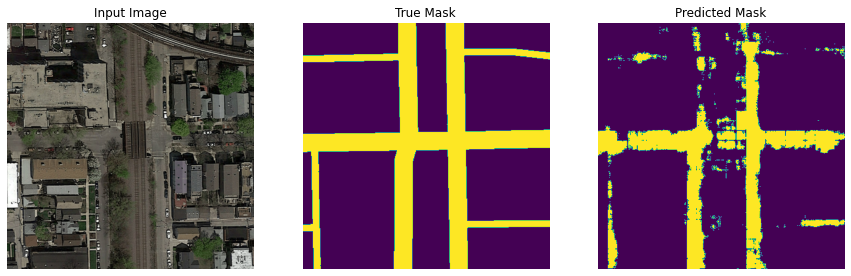

In [16]:
#Change number to look at a different datapoint
show_predictions(valid_dataset, 2)

## Evaluate and Save

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 200, 200, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50, 50, 512)  2656256     model[1][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 50, 704)  0           sequential[0][0]                 
                                                                 model[1][2]                

In [18]:
!mkdir -p checkpoints
model.save_weights("checkpoints/first_unet.ckpt")

## Perform inference on actual test data
### Load & check model

In [19]:
latest = tf.train.latest_checkpoint("checkpoints")
latest

'checkpoints/first_unet.ckpt'

In [20]:
model.load_weights(latest)

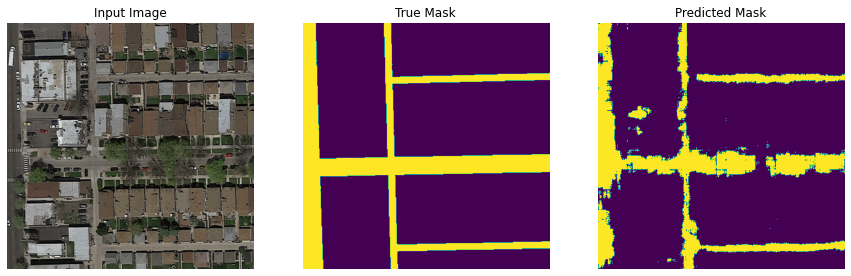

In [21]:
show_predictions(valid_dataset, 2)

### Perform inference on test pictures

In [22]:
!rm -rf data/test_images/masks
!mkdir data/test_images/masks

In [23]:
data_dir = pathlib.Path('.', 'data', 'test_images').resolve()
list_ds = tf.data.Dataset.list_files(str(data_dir/'test_images/*'))

In [24]:
def read_image_inf(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (TESTDATA_WIDTH, TESTDATA_HEIGHT))
    img = tf.image.convert_image_dtype(img, tf.float32) # Cast and normalize the image to [0,1]
    img = tf.image.per_image_standardization(img)
    return img

def infer_path(file_path):
    img = read_image_inf(file_path)
    img_topleft = tf.image.crop_to_bounding_box(img, 0, 0, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_topright = tf.image.crop_to_bounding_box(img, TESTDATA_WIDTH - NETWORK_WIDTH, 0, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_botleft = tf.image.crop_to_bounding_box(img, 0, TESTDATA_HEIGHT - NETWORK_HEIGHT, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_botright = tf.image.crop_to_bounding_box(img, TESTDATA_WIDTH - NETWORK_WIDTH, TESTDATA_HEIGHT - NETWORK_HEIGHT, NETWORK_WIDTH, NETWORK_HEIGHT)
    mask_topleft = model.predict(img_topleft[tf.newaxis, ...])
    mask_topright = model.predict(img_topright[tf.newaxis, ...])
    mask_botleft = model.predict(img_botleft[tf.newaxis, ...])
    mask_botright = model.predict(img_botright[tf.newaxis, ...])
    mask_left = [tf.image.crop_to_bounding_box(mask_topleft, 0, 0, 304, 304),
                 tf.image.crop_to_bounding_box(mask_botleft, 0, NETWORK_HEIGHT - 304, 304, 304)]
    mask_left = tf.concat(mask_left, 2)
    mask_right = [tf.image.crop_to_bounding_box(mask_topright, NETWORK_WIDTH - 304, 0, 304, 304),
                 tf.image.crop_to_bounding_box(mask_botright, NETWORK_WIDTH - 304, NETWORK_HEIGHT - 304, 304, 304)]
    mask_right = tf.concat(mask_right, 2)
    pred_mask = tf.concat([mask_left, mask_right], 1)
    mask = create_mask(pred_mask)
    return img, mask

def infer_and_save(file_path, displayResults=False):
    img, mask = infer_path(file_path)
    mask_path = tf.strings.regex_replace(file_path, "test_images/test_images", "test_images/masks")
    mask_int = tf.cast(mask * 255, tf.uint8)
    mask_enc = tf.image.encode_png(mask_int)
    tf.io.write_file(mask_path, mask_enc)
    if displayResults:
        mask_read = read_mask(mask_path)
        display([img, mask, mask_read])

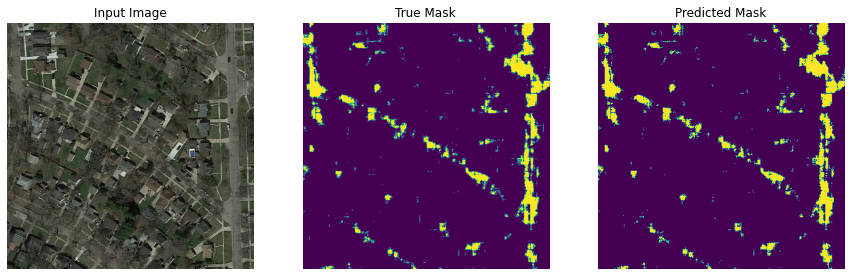

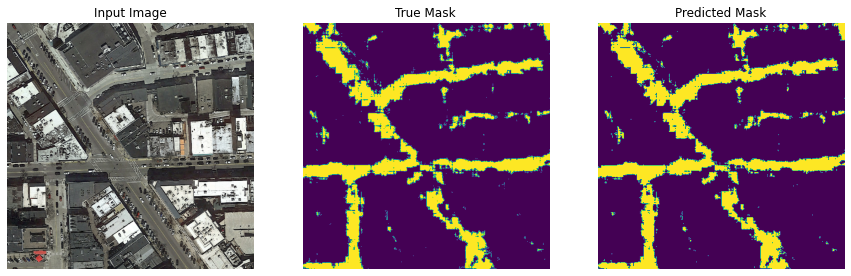

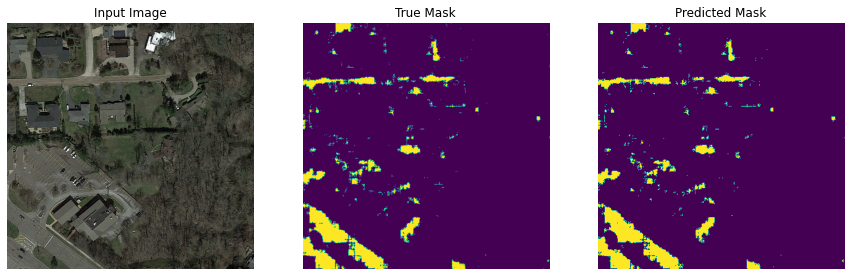

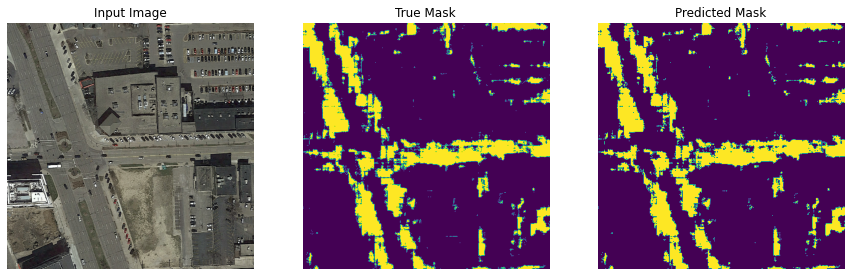

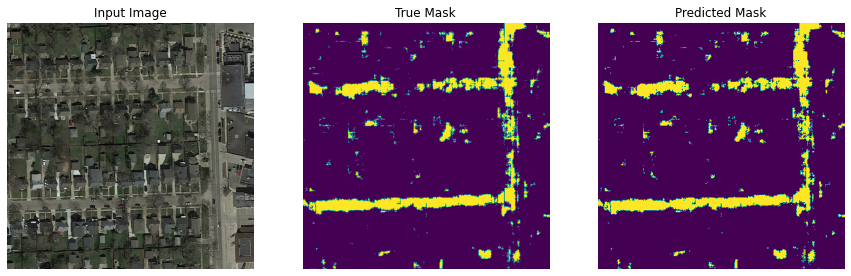

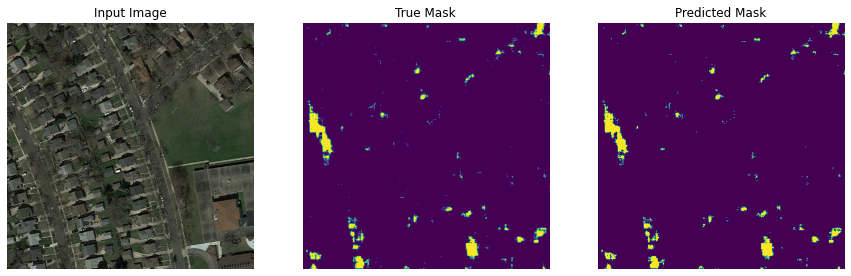

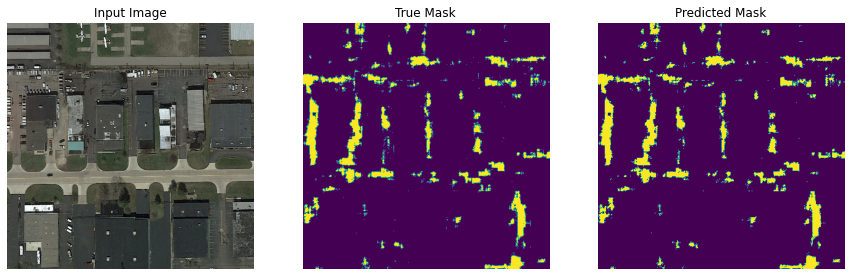

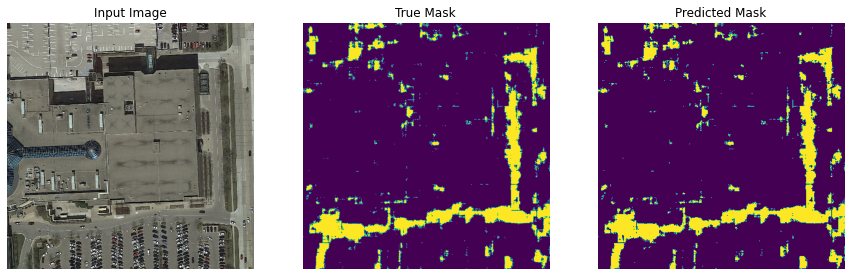

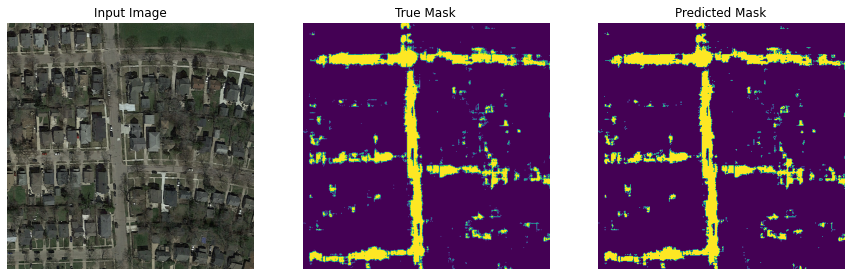

In [25]:
for idx, file_path in enumerate(list_ds):
    showResult = ((idx+1) % 10 == 0)
    infer_and_save(file_path, displayResults=showResult)

### Create submission file

In [26]:
from mask_to_submission import masks_to_submission

In [27]:
submission_filename = 'submissions/sub02_moreTrainingData.csv'
list_m = tf.data.Dataset.list_files(str(data_dir/'masks/*'))
posix_filenames = list(data_dir.glob('masks/*'))
image_filenames = []
for p in posix_filenames:
    image_filename = str(p)
#     print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)